# Fully connected TensorFlow model - Check required training epochs

## Aims

* Ascertain how many training epochs are needed to train a fully connected TensorFlow neural net. This will be used in future training.

## Basic methodology

* Models are fitted to previously split training and test data sets. 

* MinMax scaling is used (all features are scaled 0-1 based on the feature min/max).

* Model has two hidden layers, each with the number of neurons being 2x the number of features. Prior studies show performance of the network is similar across all models with this complexity or more. A dropout value of 0.5 is used based on previous exploration.

* A batch size of 32 is used ("Friends don't let friends use mini-batches larger than 32". Yan LeCun on paper: arxiv.org/abs/1804.07612)

Model structure:

* Input layer
* Dense layer (# neurons = 2x features, ReLu activation)
* Batch normalisation 
* Dropout layer
* Dense layer (# neurons = 2x features, ReLu activation)
* Batch normalisation 
* Dropout layer
* Output layer (single sigmoid activation)

In [2]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

## Load modules

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

# sklearn for pre-processing
from sklearn.preprocessing import MinMaxScaler

# TensorFlow api model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from tensorflow.keras.losses import binary_crossentropy

## Function to scale data (minmax scaling)

In [5]:
def scale_data(X_train, X_test):
    """Scale data 0-1 based on min and max in training set"""
    
    # Initialise a new scaling object for normalising input data
    sc = MinMaxScaler()

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_sc = sc.transform(X_train)
    test_sc = sc.transform(X_test)
    
    return train_sc, test_sc    

## Define neural net

In [6]:
def make_net(number_features, expansion=2, learning_rate=0.003, dropout=0.5):
    
    # Clear Tensorflow
    K.clear_session()
    
    # Input layer
    inputs = layers.Input(shape=number_features)
    
    # Dense layer 1
    dense_1 = layers.Dense(
        number_features * expansion, activation='relu')(inputs)
    norm_1 = layers.BatchNormalization()(dense_1)
    dropout_1 = layers.Dropout(dropout)(norm_1)
    
    # Dense layer 2
    dense_2 = layers.Dense(
        number_features * expansion, activation='relu')(dropout_1)
    norm_2 = layers.BatchNormalization()(dense_2)
    dropout_2 = layers.Dropout(dropout)(norm_2)    
 
    # Outpout (single sigmoid)
    outputs = layers.Dense(1, activation='sigmoid')(dropout_2)
    
    # Build net
    net = Model(inputs, outputs)
    
    # Compiling model
    opt = Adam(lr=learning_rate)
    net.compile(loss='binary_crossentropy',
    optimizer=opt,
    metrics=['accuracy'])
    return net

## Fit models

Model 0: Accuracy train 0.878 Accuracy test 0.846


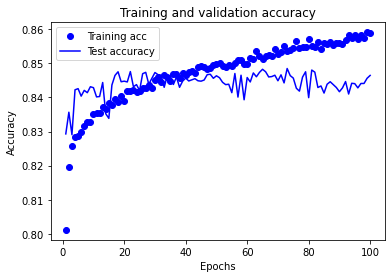

Model 1: Accuracy train 0.879 Accuracy test 0.842


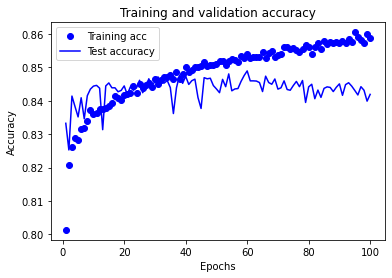

Model 2: Accuracy train 0.873 Accuracy test 0.838


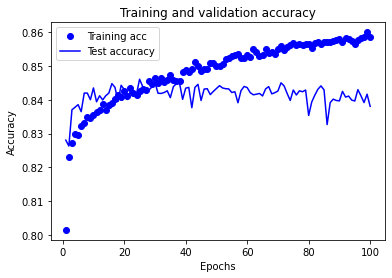

Model 3: Accuracy train 0.875 Accuracy test 0.846


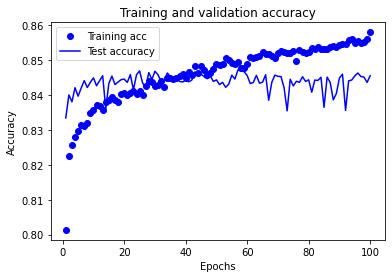

Model 4: Accuracy train 0.874 Accuracy test 0.840


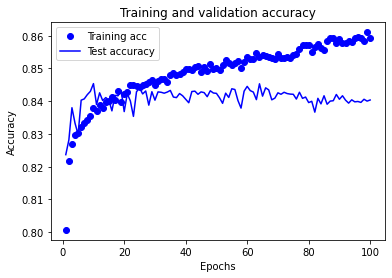

In [7]:
# Loop through 5 k-folds
test_acc = []

for k in range(5):
    
    # Load data
    train = pd.read_csv(f'../data/kfold_5fold/train_{k}.csv')
    test = pd.read_csv(f'../data/kfold_5fold/test_{k}.csv')
    
    # OneHot encode stroke team
    coded = pd.get_dummies(train['StrokeTeam'])
    train = pd.concat([train, coded], axis=1)
    train.drop('StrokeTeam', inplace=True, axis=1)
    coded = pd.get_dummies(test['StrokeTeam'])
    test = pd.concat([test, coded], axis=1)
    test.drop('StrokeTeam', inplace=True, axis=1)
    
    # Split into X, y
    X_train_df = train.drop('S2Thrombolysis',axis=1) 
    y_train_df = train['S2Thrombolysis']
    X_test_df = test.drop('S2Thrombolysis',axis=1) 
    y_test_df = test['S2Thrombolysis'] 
        
    # Convert to NumPy
    X_train = X_train_df.values
    X_test = X_test_df.values
    y_train = y_train_df.values
    y_test = y_test_df.values
    
    # Scale data
    X_train_sc, X_test_sc = scale_data(X_train, X_test)
    
    # Define network
    number_features = X_train_sc.shape[1]
    model = make_net(number_features)
    
    # Define save checkpoint callback (only save if new best validation results)
    checkpoint_cb = keras.callbacks.ModelCheckpoint(
        'model_checkpoint.h5', save_best_only=True)
    
    # Define early stopping callback: Stop when no validation improvement
    # Restore weights to best validation accuracy
    early_stopping_cb = keras.callbacks.EarlyStopping(
        patience=50, restore_best_weights=True)
    
    # Train model (including class weights)
    history = model.fit(X_train_sc,
                        y_train,
                        epochs=100,
                        batch_size=32,
                        validation_data=(X_test_sc, y_test),
                        verbose=0)
    #                   callbacks=[checkpoint_cb, early_stopping_cb]
    
    ### Test model
    probability = model.predict(X_train_sc)
    y_pred_train = probability >= 0.5
    y_pred_train = y_pred_train.flatten()
    accuracy_train = np.mean(y_pred_train == y_train)
    print(f'Model {k}: Accuracy train {accuracy_train:0.3f}', end=' ')
    
    probability = model.predict(X_test_sc)
    y_pred_test = probability >= 0.5
    y_pred_test = y_pred_test.flatten()
    accuracy_test = np.mean(y_pred_test == y_test)
    print(f'Accuracy test {accuracy_test:0.3f}')
    
    # Plot training accuracy
    history_dict = history.history

    acc_values = history_dict['accuracy']
    val_acc_values = history_dict['val_accuracy']
    test_acc.append(val_acc_values)
    epochs = range(1, len(acc_values) + 1)

    plt.plot(epochs, acc_values, 'bo', label='Training acc')
    plt.plot(epochs, val_acc_values, 'b', label='Test accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
    
    # Remove model
    del model

In [8]:
results = np.array(test_acc)
mean_results = results.mean(axis=0)

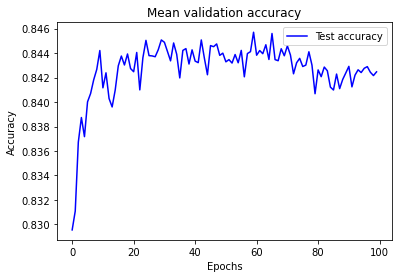

In [9]:
epochs = range(100)
plt.plot(epochs, mean_results, 'b', label='Test accuracy')
plt.title('Mean validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Observations

* Training set accuracy continues to increase throughout the training period of the experiment.

* Test set accuracy rises, plateaus, and then declines over the training period of the experiment. The plateau occurs between approximately 25 and 70 epochs.

* A training period of 30 epochs (mini-batch size 32) may be used in future experiments using this model structure.